# TD1 – Kppv et réseaux de neurones pour la classification d'images

L’objectif de ce TD est d'écrire en langage Python un programme complet de classification
d'images. Deux modèles de classification seront successivement développés et
expérimentés : les k-plus-proches-voisins et les réseaux de neurones. Le module numpy sera
utilisé pour la manipulation des matrices et le module scikit-image
1 pour la manipulation des
images.

## 1. Présentations des données pour les expérimentations

La base d'images qui sera utilisée pour les expérimentations est CIFAR-10 qui consiste en 60
000 images en couleur de taille 32x32 réparties en 10 classes (avion, voiture, oiseau, chat, ...). Cette base peut être obtenue à l'adresse https://www.cs.toronto.edu/~kriz/cifar.html où
sont également données les indications pour lire les données

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import data, exposure
rng = np.random.default_rng()
from sklearn.metrics import confusion_matrix
import itertools
import cv2
from skimage.color import rgb2gray
from skimage.feature import hog
from skimage.feature import local_binary_pattern
np.random.seed(1) # pour que l'exécution soit déterministe

In [3]:
FILES_tot = [
    '/cifar-10-batches-py/data_batch_1',
    '/cifar-10-batches-py/data_batch_2',
    '/cifar-10-batches-py/data_batch_3',
    '/cifar-10-batches-py/data_batch_4',
    '/cifar-10-batches-py/data_batch_5',
    '/cifar-10-batches-py/test_batch']

In [4]:
FILES_batch_1 = [
    '/cifar-10-batches-py/data_batch_1']

In [5]:
path=r"C:/Users/thiba/OneDrive/Documents/Documents/COURS/CENTRALE LYON/Option/IA/data"
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [6]:
label_file_name="/cifar-10-batches-py/batches.meta"

In [7]:
def unpickle(filename):
    import pickle
    with open(filename, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

## 2. Système de classification à base de l'algorithme des kppv

L'objectif est de développer un classifieur de type kppv. Sa mise en œuvre doit être
optimisée en utilisant une représentation vectorielle des données : seuls des calculs
matriciels doivent être réalisés lors de la phase de calcul des distances, et donc cette
fonction ne doit pas comporter de boucle (à l’exception de celle portant sur les batchs de
test si l’évaluation est réalisée de cette manière). Le module Python numpy devra être utilisé.

### 2.1 Développement du classifieur

#### fonction lecture_cifar

Prenant en argument le chemin du répertoire contenant les
données, et renvoyant une matrice X de taille NxD où N correspond au nombre de données
disponibles, et D à la dimension de ces données (nombre de valeurs numériques décrivant
les données), ainsi qu'un vecteur Y de taille N dont les valeurs correspondent au code de la
classe de la donnée de même indice dans X.

In [8]:
def lecture_cifar(path,FILES):
    X, Y = None, None
    for filename in FILES:
        extracted_file = unpickle(path+filename)
        local_data, local_labels = np.array(extracted_file[b'data'], dtype='float32'), np.array(extracted_file[b'labels'], dtype='float32')
        if type(X) == np.ndarray and type(Y) == np.ndarray:
            X, Y = np.vstack((X, local_data)), np.hstack((Y, local_labels))
        else:
            X, Y = local_data, local_labels
    return X, Y

In [9]:
X,Y=lecture_cifar(path,FILES_batch_1)

In [10]:
print('Dimension des données:',np.shape(X))
print('Dimension des labels:',np.shape(Y))

Dimension des données: (10000, 3072)
Dimension des labels: (10000,)


#### fonction visualisation des images par classes

In [11]:
def visualisation_classe(X,Y,samples_per_class,classes):
    num_classes=len(classes)
    for y, cls in enumerate(classes):
        idxs = np.flatnonzero(Y == y) # renvoie les index dans Y correspondant au label de y
        idxs = np.random.choice(idxs, samples_per_class, replace=False) # parmis les index précédents en choisi samples_per_class au hasard
        for i, idx in enumerate(idxs):
            plt_idx = i * num_classes + y + 1
            plt.subplot(samples_per_class, num_classes, plt_idx)
            if len(X[idx])>1026:
                R = X[idx][0:1024].reshape(32,32)
                G = X[idx][1024:2048].reshape(32,32)
                B = X[idx][2048:].reshape(32,32)
                img = np.dstack((R,G,B))
            else:
                img = X[idx]
            plt.imshow(img.astype(np.uint8))
            plt.axis('off')
            if i == 0:
                plt.title(cls)
    plt.show()

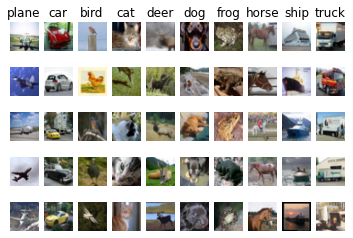

In [12]:
samples_per_class=5
visualisation_classe(X,Y,samples_per_class,classes)

#### fonction normalisation 

prenant en argument la matrice X et normalisant chaque valeur de cette matrice par son maximum (d'un intervalle de 0-255 à 0-1)

In [13]:
def normalisation(X):
    return X/255

In [14]:
X_norm=normalisation(X)

#### fonction decoupage_donnees

prenant en argument les matrices X et Y, et renvoyant les données
d'apprentissage et de test : Xapp, Yapp, Xtest, Ytest.

In [15]:
def decoupage_donnees(X,Y, split=0.8):
    N, D = X.shape
    full_data = np.hstack((X, Y.reshape(-1, 1)))
    rng.shuffle(full_data)
    Fullapp, Fulltest = full_data[:int(split * N), :], full_data[int(split * N):, :]
    return Fullapp[:, :D], Fullapp[:, -1], Fulltest[:, :D], Fulltest[:, -1]

In [16]:
Xapp, Yapp, Xtest, Ytest=decoupage_donnees(X_norm,Y, split=0.8)

#### fonction kppv_distances 

prenant en argument Xtest et Xapp et renvoyant la
matrice des distances Dist entre toutes les données de l'ensemble de test par rapport à
toutes les données de l'ensemble d'apprentissage.

In [17]:
def kppv_distances(Xtest,Xapp):
    num_test = Xtest.shape[0]
    num_train = Xapp.shape[0]
    dists = np.zeros((num_test, num_train), dtype='float32') # matrice de taille (nombre d'image test) X (nombre d'image train) remplie de 0
   
    Xapp_Xtest_product=2*Xtest.dot(Xapp.T) #terme 2ab de (a-b)^2
    Xapp_int=(Xapp*Xapp).sum(axis=1)*np.ones((num_test, 1)) #terme a^2 de (a-b)^
    Xtest_int=(Xtest*Xtest).sum(axis=1)[:, np.newaxis]*np.ones((1, num_train))  #terme b^2 de (a-b)^2
    
    dists = np.sqrt(Xapp_int + Xtest_int - Xapp_Xtest_product)  # chaque coefficient correspond à la somme totale des différences de distances en norme euclidienne entre chaque pixel de chaque image test VS train 
    
    return dists

In [18]:
dists=kppv_distances(Xtest,Xapp)

#### fonction kppv_predict

prenant en argument Dist, Yapp et K le nombre de voisins
et renvoyant le vecteur Ypred des classes prédites pour les éléments de Xtest

In [19]:
def kppv_predict(Yapp, dists, k):
    num_test = dists.shape[0]
    Ypred = np.zeros(num_test) # création d'un vecteur nul de taille (nombre d'image test) x 1
    for i in range(num_test): # On parcourt toutes les images test
        sorted_dist = np.argsort(dists[i]) #renvoie un array d'indice trié par valeur de la plus petite à la plus grande
        closest_y=[Yapp[j] for j in sorted_dist[0:k]]  # renvoie les labels des k premiers indices de la liste triée comme plus proche voisin (images du set de test dont la somme de la différence des pixels est la plus faible)
        Ypred[i]= (np.argmax(np.bincount(closest_y))) # np.bincount compte le nombre d'occurence de chaque label parmis les k voisins et np.argmax séléctionne le label avec le plus d'occurence comme prédiction.

    return Ypred

In [20]:
k=10
Ypred=kppv_predict(Yapp, dists, k)

#### fonction evaluation_classifieur

prenant en argument Ytest et Ypred et renvoyant
le taux de classification (Accuracy)

In [21]:
def evaluation_classifieur(Ypred,Ytest):
    num_test = len(Ytest)
    num_correct = np.sum(Ypred == Ytest)
    accuracy = float(num_correct) / num_test
    return accuracy

In [22]:
accuracy=evaluation_classifieur(Ypred,Ytest)
print('Pour un k de',k, f' on obtient une précision de {accuracy:.2%}')

Pour un k de 10  on obtient une précision de 29.35%


#### fonction plot_confusion_matrix

Prenant en argument Ypred et Ytest pour connaitre la 
performance de prédiction sur chaque classe et constater où se font les erreurs

In [23]:
def plot_confusion_matrix(Ytest, Ypred, classes,title='Confusion matrix',cmap=plt.cm.Blues):
    cm=confusion_matrix(Ytest, Ypred)
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


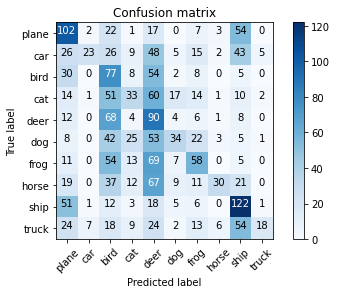

In [24]:
plot_confusion_matrix(Ytest, Ypred, classes,title='Confusion matrix',cmap=plt.cm.Blues)

##### Remarques

On peut constater que l'algorithme a tendance à confondre les animaux entre eux (pour 201 images dde chats il y a 26 bonnes prédictions, 145 d'autres animaux notamment 52 pour l'oiseau et seulement 31 predictions de moyen de transport). A l'instar les moyens de transport ont aussi tendance à être confondu entre eux: pour truck (camion) il y 214 images de camions, 21 sont correctement prédites et 110 sont des images d'autres transports (notamment le bateau avec 71 prédictions) contre donc seulement 83 prédictions d'animaux (sachant qu'il y a 6 classes d'animaux contre 4 classes de transport).

### 2.2 Expérimentations

Des expérimentations devront être réalisées en étudiant les variations suivantes : 
- influence du nombre de voisins K sur l'efficacité du classifieur évaluée à l'aide du taux de classification (Accuracy). 
- représentation des images par des descripteurs (LBP, HOG, ...) en utilisant le module scikitimage. 
- utilisation de la validation croisée à N répertoires (N-fold cross-validation) plutôt qu'un découpage en deux sous-ensembles fixes d'apprentissage et de test.

#### Etude d'influence du nombre de voisin K sur l'efficacité 

In [25]:
k_choices=[1, 3, 5, 8, 10, 12, 15, 20, 50, 100]
ACC=[]
for k in k_choices:
    Ypred=kppv_predict(Yapp, dists, k)
    accuracy=evaluation_classifieur(Ypred,Ytest)
    ACC.append(accuracy)

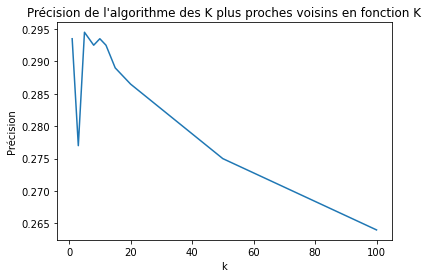

In [26]:
plt.figure()
plt.plot(k_choices, ACC)
plt.xlabel("k")
plt.ylabel("Précision")
plt.title("Précision de l'algorithme des K plus proches voisins en fonction K")
plt.show()

In [27]:
i_max=list(ACC).index(np.max(ACC[1:]))
accuracy_max=np.max(ACC)
k_max=k_choices[i_max]
print("L'hyperparamètre k optimal est",k_max, f'et on obtient une précision de {accuracy_max:.2%}')

L'hyperparamètre k optimal est 5 et on obtient une précision de 29.45%


#### test de l'algorithme avec l'utilisation d'une validation croisée à N paquet

In [28]:
def cross_validation(X,Y,num_folds,K): 
    Xapp, Yapp, Xtest, Ytest=decoupage_donnees(X,Y, split=0.8)

    Xapp_folds = []
    Yapp_folds = []

    Xapp_folds = np.array_split(Xapp,num_folds)
    Yapp_folds = np.array_split(Yapp,num_folds)
    k_to_accuracies = {}

    for k in K:
        k_to_accuracies[k] = []
        for num_knn in range(0,num_folds):
            X_test = Xapp_folds[num_knn]
            y_test = Yapp_folds[num_knn]
            X_train = Xapp_folds
            y_train = Yapp_folds
            
            X_train = np.delete(X_train,num_knn,0)
            X_train = np.concatenate((X_train),axis = 0)
            y_train = np.delete(y_train,num_knn,0)
            y_train = np.concatenate((y_train),axis = 0)
            
            dists=kppv_distances(X_test,X_train)
            Ypred=kppv_predict(y_train, dists, k)
            accuracy=evaluation_classifieur(Ypred,y_test)
            
            k_to_accuracies[k].append(accuracy)
            
    return k_to_accuracies

In [29]:
num_folds=5
k_to_accuracies=cross_validation(X,Y,num_folds,k_choices)

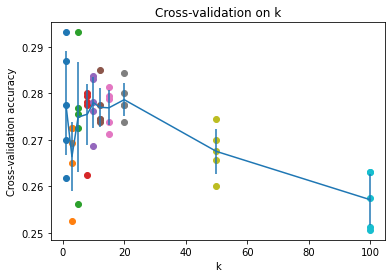

In [30]:
plt.figure()
for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [31]:
i_max=list(accuracies_mean).index(np.max(accuracies_mean[1:]))
accuracy_max=np.max(accuracies_mean)
k_max=k_choices[i_max]
print("L'hyperparamètre k optimal et sa précision sont donc: k = %d, accuracy = %f" % (k_max, accuracy_max))

L'hyperparamètre k optimal et sa précision sont donc: k = 20, accuracy = 0.278625


##### Remarques

La validation croisée permet d'avoir plus den robustesse dans le choix de k étant donnée que l'on voit qu'il peut exister une certaine variation de précision à un k donnée entre les N sous ensembles

#### test de l'algorithme avec l'utilisation de descripteur : HOG

In [32]:
# Configuration du HOG descriptor
normalize = True                     
block_norm = 'L2-Hys'     
orientations = 8           
pixels_per_cell = [8, 8]  
cells_per_block = [1, 1]

In [33]:
def hog_prep(X):
    X_hog=[]
    for i in range(len(X)):
        R = X[i][0:1024].reshape(32,32)
        G = X[i][1024:2048].reshape(32,32)
        B = X[i][2048:].reshape(32,32)
        img = np.dstack((R,G,B))
        fd, hog_image = hog(img, orientations, pixels_per_cell,cells_per_block,block_norm, visualize=True,multichannel=True)
        X_hog.append(hog_image)
    return X_hog

In [34]:
X_hog=hog_prep(X)

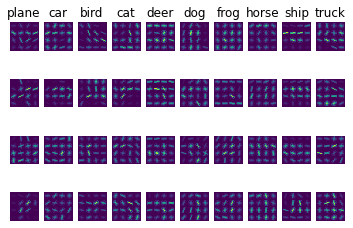

In [35]:
samples_per_class=4
visualisation_classe(X_hog,Y,samples_per_class,classes)

In [36]:
np.shape(X_hog)[0]

10000

In [37]:
X_hog=np.array(X_hog, dtype='float32') #conversion en array
X_hog=X_hog.reshape(np.shape(X_hog)[0], 1024) # redimenssionnement pour avoir tous les pixels à la suite

In [38]:
k=15
X_hogapp, Yapp, X_hogtest, Ytest=decoupage_donnees(X_hog,Y, split=0.8)
dists=kppv_distances(X_hogtest,X_hogapp)
Ypred=kppv_predict(Yapp, dists, k)
accuracy=evaluation_classifieur(Ypred,Ytest)
print('Pour un k de',k, f' on obtient une précision de {accuracy:.2%}')

Pour un k de 15  on obtient une précision de 42.70%


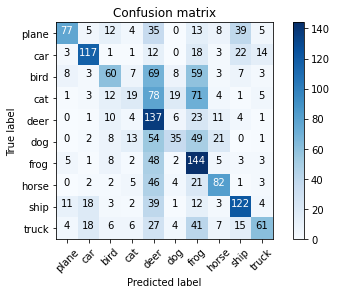

In [39]:
plot_confusion_matrix(Ytest, Ypred, classes,title='Confusion matrix',cmap=plt.cm.Blues)

In [40]:
k_choices=[1, 3, 5, 8, 10, 12, 15, 20, 50, 100]
ACC=[]
for k in k_choices:
    Ypred=kppv_predict(Yapp, dists, k)
    accuracy=evaluation_classifieur(Ypred,Ytest)
    ACC.append(accuracy)
k_choices=[1, 3, 5, 8, 10, 12, 15, 20, 50, 100]
ACC=[]
for k in k_choices:
    Ypred=kppv_predict(Yapp, dists, k)
    accuracy=evaluation_classifieur(Ypred,Ytest)
    ACC.append(accuracy)

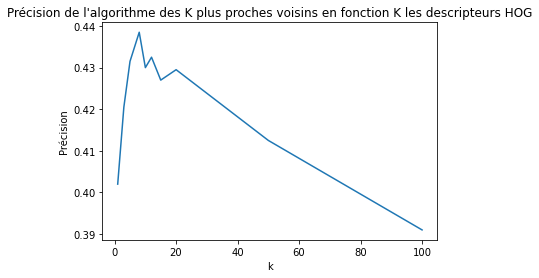

In [41]:
plt.figure()
plt.plot(k_choices, ACC)
plt.xlabel("k")
plt.ylabel("Précision")
plt.title("Précision de l'algorithme des K plus proches voisins en fonction K les descripteurs HOG")
plt.show()

In [42]:
i_max=list(ACC).index(np.max(ACC[1:]))
accuracy_max=np.max(ACC)
k_max=k_choices[i_max]
print("Dans le cas de descripteur HOG l'hyperparamètre k optimal est",k_max, f'et on obtient une précision de {accuracy_max:.2%}')

Dans le cas de descripteur HOG l'hyperparamètre k optimal est 8 et on obtient une précision de 43.85%


##### Remarques

On observe qu'avec les descripteurs HOG on arrive à augmenter la précision de 15 à 20% ces descripteurs sont donc plus adaptés. 

#### test de l'algorithme avec l'utilisation de descripteur : LBP

In [43]:
# Configuration pour LBP
METHOD = 'uniform'
radius = 1
n_points = 8 * radius

In [44]:
def rgb_to_gray(X):
    X_gray=[]
    for i in range(len(X)):
        R = X[i][0:1024].reshape(32,32)
        G = X[i][1024:2048].reshape(32,32)
        B = X[i][2048:].reshape(32,32)
        img = np.dstack((R,G,B))
        grayscale = rgb2gray(img)
        X_gray.append(grayscale)
    return X_gray

In [45]:
def lbp_prod(X, method, p, r):
    X_hist=[]
    X_lbp=[]
    for x in X:
        lbp = local_binary_pattern(x, p, r, method)  
        his, _ = np.histogram(lbp,normed=True, bins=p+2, range=(0, p+2))
        X_hist.append(his)
        X_lbp.append(lbp)
    return X_hist,X_lbp

In [46]:
X_gray=rgb_to_gray(X)

In [47]:
X_hist,X_lbp=lbp_prod(X_gray,METHOD,n_points,radius)

<ipython-input-45-f93277a0cf7f>:6: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  his, _ = np.histogram(lbp,normed=True, bins=p+2, range=(0, p+2))


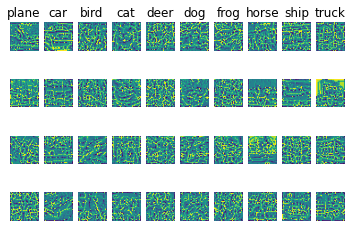

In [48]:
samples_per_class=4
visualisation_classe(X_lbp,Y,samples_per_class,classes)

In [49]:
X_hist=np.array(X_hist, dtype='float32') #conversion en arrayX_lb
X_lbp=np.array(X_lbp, dtype='float32').reshape(10000,1024)

In [50]:
k=10
X_histapp, Yapp, X_histtest, Ytest=decoupage_donnees(X_hist,Y, split=0.8)
dists=kppv_distances(X_histtest,X_histapp)
Ypred=kppv_predict(Yapp, dists, k)
accuracy=evaluation_classifieur(Ypred,Ytest)
print('Pour un k de',k, f' on obtient une précision de {accuracy:.2%}')

Pour un k de 10  on obtient une précision de 22.60%


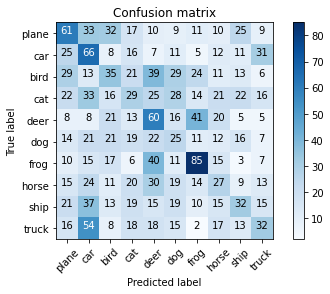

In [51]:
plot_confusion_matrix(Ytest, Ypred, classes,title='Confusion matrix',cmap=plt.cm.Blues)

In [52]:
k_choices=[1, 3, 5, 8, 10, 12, 15, 20, 50, 100]
ACC=[]
for k in k_choices:
    Ypred=kppv_predict(Yapp, dists, k)
    accuracy=evaluation_classifieur(Ypred,Ytest)
    ACC.append(accuracy)
k_choices=[1, 3, 5, 8, 10, 12, 15, 20, 50, 100]
ACC=[]
for k in k_choices:
    Ypred=kppv_predict(Yapp, dists, k)
    accuracy=evaluation_classifieur(Ypred,Ytest)
    ACC.append(accuracy)

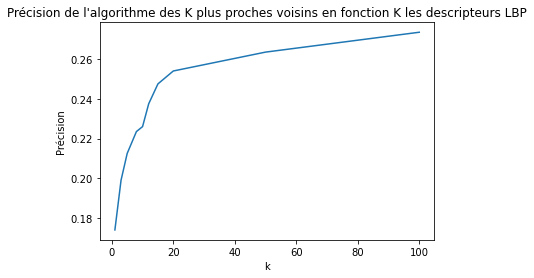

In [53]:
plt.figure()
plt.plot(k_choices, ACC)
plt.xlabel("k")
plt.ylabel("Précision")
plt.title("Précision de l'algorithme des K plus proches voisins en fonction K les descripteurs LBP")
plt.show()

In [54]:
i_max=list(ACC).index(np.max(ACC[1:]))
accuracy_max=np.max(ACC)
k_max=k_choices[i_max]
print("Dans le cas de descripteur LBP l'hyperparamètre k optimal est",k_max, f'et on obtient une précision de {accuracy_max:.2%}')

Dans le cas de descripteur LBP l'hyperparamètre k optimal est 100 et on obtient une précision de 27.35%


##### Remarques

On observe qu'avec les descripteurs LBP on améliore pas particulièrement la précision par rapport au features de base. 
On selectionnera donc comme features finales les descripteurs HOG

## 3. Système de classification à base de réseaux de neurones

### 3.1 Développement du classifieur

L'objectif ici est de développer un classifieur s'appuyant sur un réseau de neurones de type
perceptron (multi-couches). Les fonctions de lecture et découpage des données réalisées précédemment pourront être
réutilisées (éventuellement adaptées) pour ce classifieur. Ci-dessous, un code Python permettant une passe avant (forward) et le calcul de la fonction
de perte de type MSE (Mean Square Error) dans un réseau contenant une couche cachée et
utilisant la fonction sigmoïde comme fonction d'activation.
Compléter ce code pour réaliser la phase de descente du gradient afin de permettre
l'apprentissage du réseau. Adapter ensuite ce réseau pour permettre la classification d’images. Les expérimentations
pourront être faites en utilisant la base CIFAR-10.

#### fonction utile

In [55]:
def sigmoid(out):
    return 1.0 / (1.0 + np.exp(-out))

In [56]:
def sigmoid_backward(dA, Z):
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    return dZ

In [57]:
def relu(out):
    A = np.maximum(out, 0.01*out)
    return A

In [58]:
def relu_backward(dA, Z):
    dZ = np.array(dA) 
    dZ=np.where(dZ<=0,0.01,1)
    return dZ

In [59]:
def compute_cross_entropy_cost(AL, Y):
    m = Y.shape[1]
    cost = (-1 / m) * np.sum(np.multiply(Y, np.log(AL)) + np.multiply(1 - Y, np.log(1 - AL))) # cross-entropy cost
    cost = np.squeeze(cost)      # pour retourner un réel et pas [[5]] au lieu de 5
    return cost

In [60]:
def compute_MSE_cost(AL, Y):
    m = Y.shape[1]
    cost = (1 / m) * np.square(AL - Y).sum() / 2 # MSE cost
    cost = np.squeeze(cost)      
    return cost

In [61]:
def reshape_label_input(Y):
    Y_new=[]
    for y in Y:
        liste_Y=len(classes)*[0]
        liste_Y[int(y)]=1 #on donne la valeur de 1 à l'indice dans la liste de 10 correspondant au label de l'image
        Y_new.append(liste_Y)
    Y_new=np.array(Y_new,dtype='float32')
    return Y_new

In [62]:
def batch_normalization(X):
    mean=np.mean(X, axis=1).reshape(np.shape(X)[0],1)
    var=np.var(X, axis=1).reshape(np.shape(X)[0],1)
    batch_normed=(X-mean)
    batch_normed=np.divide(batch_normed,np.sqrt(var))
    return batch_normed

In [63]:
def pre_processing(X):
    X_centered=X/255
    mean_image=np.mean(X_centered, axis=1).reshape(np.shape(X_centered)[0],1)
    X_normed=X_centered-mean_image
    return X_normed

In [64]:
def iterate_minibatches(inputs, targets, batchsize):
    indices = np.arange(inputs.shape[1])
    np.random.shuffle(indices)
    for start_idx in range(0, inputs.shape[1] - batchsize + 1, batchsize):
        batch_index = indices[start_idx:start_idx + batchsize]
        yield inputs[:,batch_index], targets[:,batch_index]

In [65]:
def initialize_parameters_deep(layer_dims):
    parameters = {}
    L = len(layer_dims)            # nombre de couches
    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l - 1])/np.sqrt(layer_dims[l])
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        parameters['moment1' + str(l)] = np.zeros((layer_dims[l], layer_dims[l - 1]))
        parameters['moment2' + str(l)] = np.zeros((layer_dims[l], layer_dims[l - 1]))
        
    return parameters

In [66]:
def linear_forward(A, W, b):
    Z = np.dot(W, A) + b
    return Z

In [67]:
def linear_activation_forward(A_prev, W, b, activation):
    if activation == "sigmoid":
        Z = linear_forward(A_prev, W, b)
        A = sigmoid(Z)

    elif activation == "relu":
        Z = linear_forward(A_prev, W, b)
        A = relu(Z)

    return A,Z

In [68]:
def L_model_forward(X,layer_dims, parameters,activation):
    
    A = X
    L = len(layer_dims)               
    list_linear_output=[]
    list_activation_output=[X]
    
    if activation=='relu':
        for l in range(1, L):
            A_prev = A 
            A,Z = linear_activation_forward(A_prev, 
                                            parameters['W' + str(l)], 
                                            parameters['b' + str(l)], 
                                            activation='relu')
            list_linear_output.append(Z)
            list_activation_output.append(A)
    else:
        for l in range(1, L):
            A_prev = A 
            A,Z = linear_activation_forward(A_prev, 
                                                 parameters['W' + str(l)], 
                                                 parameters['b' + str(l)], 
                                                 activation='sigmoid')
            list_linear_output.append(Z)
            list_activation_output.append(A)
            
    return list_linear_output,list_activation_output

In [69]:
def linear_backward(dZ,A_prev,W,b):
    m = A_prev.shape[1]

    dW = np.dot(dZ, A_prev.T) / m
    db = np.squeeze(np.sum(dZ, axis=1, keepdims=True)) / m
    dA_prev = np.dot(W.T, dZ)
    
    return dA_prev, dW, db

In [70]:
def linear_activation_backward(dA,Z,A_prev,W,b, activation):
    
    if activation == "relu":
        dZ = relu_backward(dA, Z)
        
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, Z)

    dA_prev, dW, db = linear_backward(dZ,A_prev,W,b)
    
    return dA_prev, dW, db

In [71]:
def L_model_backward(Y,layer_dims,list_linear_output,list_activation_output,parameters,activation,cost):

    grads = {}
    L = len(layer_dims)
    m = list_activation_output[-1].shape[1]
    Y = Y.reshape(list_activation_output[-1].shape) 
    
    if cost=='MSE':
        dAL = 2*(list_activation_output[-1]-Y)
    if cost=='Cross-entropy':
        dAL = - (np.divide(Y, list_activation_output[-1]) - np.divide(1 - Y, 1 - list_activation_output[-1]));
 
    W=parameters['W'+str(L-1)]
    b=parameters['b'+str(L-1)]
    Z = list_linear_output[-1]
    A_prev= list_activation_output[-2]
    grads["dA" + str(L-1)], grads["dW" + str(L-1)], grads["db" + str(L-1)] = linear_activation_backward(dAL,Z,A_prev,W,b, activation)
    
    for l in range(2, L):

        current_Z = list_linear_output[-l]
        current_A_prev = list_activation_output[-l-1]
        W=parameters['W'+str(L-l)]
        b=parameters['b'+str(L-l)]
        dAL=grads["dA" + str(L-l+1)]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(dAL,current_Z,current_A_prev,W,b,activation)
        grads["dA" + str(L - l)] = dA_prev_temp
        grads["dW" + str(L - l)] = dW_temp
        grads["db" + str(L - l)] = db_temp

    return grads

In [72]:
def update_parameters(parameters, grads, learning_rate,layer_dims,L2):

    L = len(layer_dims) 
    beta1=0.9
    beta2=0.999
    lambda_coef=0.02
    if L2==True:
        for l in range(1,L):
            grads["dW" + str(l)]=grads["dW" + str(l)]+lambda_coef*parameters["W" + str(l)]
    for l in range(1,L):
        parameters['moment1' + str(l)] = parameters['moment1' + str(l)]*beta1+(1-beta1)* grads["dW" + str(l)]
        parameters['moment2' + str(l)] = parameters['moment2' + str(l)]*beta2+(1-beta2)* grads["dW" + str(l)]* grads["dW" + str(l)]
        parameters["W" + str(l)] = parameters["W" + str(l)] - (learning_rate) * parameters['moment1' + str(l)]/(1e-7+np.sqrt(parameters['moment2' + str(l)]))
        parameters["b" + str(l)] = parameters["b" + str(l)] - (learning_rate) * grads["db" + str(l)].reshape(np.shape(grads["db" + str(l)])[0],1)
        
    return parameters

In [73]:
def evaluation_network_classification(X,Y,layer_dims,params,activation):
    count=0
    for i in range(np.shape(X)[1]):
        L_linear,L_activation=L_model_forward(X[:,i].reshape(np.shape(X[:,i])[0],1),layer_dims, params,activation)
        if np.argmax(L_activation[-1]) == np.argmax(Y[:,i]):
                count += 1
    accuracy=(float(count) / X.shape[1]) * 100
    return(accuracy)

In [74]:
def fit_network(X,Y,X_test,Y_test,layer_dims,n_iteration,learning_rate,batch_size,activation,cost,L2):
    params=initialize_parameters_deep(layer_dims)
    L = len(layer_dims) 
    LOSS=[]
    ACC_train=[]
    ACC_test=[]
    early_stop=False
    
    for j in range(n_iteration):
        if early_stop:
            break     
        else:
            for batch in iterate_minibatches(X, Y, batch_size):
                X_b, Y_b = batch
                X_b=batch_normalization(X_b)
                L_linear,L_activation=L_model_forward(X_b,layer_dims, params,activation)
                grads=L_model_backward(Y_b,layer_dims,L_linear,L_activation,params,activation,cost)

                if cost=='MSE':
                    Cost = compute_MSE_cost(L_activation[-1], Y_b)

                if cost=='Cross-entropy':
                    Cost = compute_cross_entropy_cost(L_activation[-1], Y_b)

                LOSS.append(Cost)
                params=update_parameters(params, grads, learning_rate,layer_dims,L2)

            accuracy_train=evaluation_network_classification(X,Y,layer_dims,params,activation)
            ACC_train.append(accuracy_train)
            accuracy_test=evaluation_network_classification(X_test,Y_test,layer_dims,params,activation)
            ACC_test.append(accuracy_test) 
        
        if len(ACC_train)>10:
            avg=np.mean(ACC_train[-10:])
            last_acc=ACC_train[-1]
            if abs(avg-last_acc)<1:
                early_stop=True
                print("Dernière itération",j,
                      "Précision max set de train:",accuracy_train,
                      "Précision max set de test:",np.max(ACC_test))
            
    return (params,LOSS,ACC_train,ACC_test)

In [75]:
def predict(X,layer_dims,params,activation):
    labels = unpickle(path+label_file_name)[b"label_names"]
    preds_label =np.shape(X)[1]*[0]
    for i in range(np.shape(X)[1]):
        L_linear,L_activation=L_model_forward(X[:,i].reshape(np.shape(X[:,i])[0],1),layer_dims, params,activation)
        preds_label[i]=np.argmax(L_activation[-1])
    return np.squeeze(preds_label)

#### exemple de reseau de neurones avec 1 couche cachée

##### initialisation 

In [ ]:
# N est le nombre de données d'entrée
# D_in est la dimension des données d'entrée
# D_h le nombre de neurones de la couche cachée
# D_out est la dimension de sortie (nombre de neurones de la couche de sortie)
N=30
D_in=[50]
D_h=[30]
D_out=[10]
# Création d'une matrice d'entrée X et de sortie Y avec des valeurs aléatoires
X = np.random.random((D_in[0],N))
Y = np.random.random((D_out[0],N ))
N_iter=2000
learning_rate=0.01

In [ ]:
layers=D_in+D_h+D_out
params=initialize_parameters_deep(layers)

In [ ]:
X_prep=pre_processing(X)

##### passe avant

In [ ]:
L_linear,L_activation=L_model_forward(X_prep,layers, params,activation='sigmoid')

#####  Calcul de la fonction perte de type MSE

In [ ]:
MSE=[]
MSE_cost_0 = compute_MSE_cost(L_activation[-1], Y)
MSE.append(MSE_cost_0)
print('erreur sans optimisation:',MSE_cost_0)

#####  phase descente de gradient

In [ ]:
grads=L_model_backward(Y,layers,L_linear,L_activation,params,activation='sigmoid',cost='MSE')

#####  mise à jour des paramètres

In [ ]:
params=update_parameters(params, grads, learning_rate,layers,L2=False)

#####  Calcul de la fonction perte de type MSE après un tour d'optimisation

In [ ]:
L_linear,L_activation=L_model_forward(X,layers, params,activation='sigmoid')
MSE_cost_1 = compute_MSE_cost(L_activation[-1], Y)
MSE.append(MSE_cost_1)
print("erreur avec 1 tour d'optimisation:",MSE_cost_1)

##### optimisation du réseau avec N itérations

In [ ]:
for i in range(N_iter):
    grads=L_model_backward(Y,layers,L_linear,L_activation,params,activation='sigmoid',cost='MSE')
    params=update_parameters(params, grads, learning_rate,layers,L2=False)
    L_linear,L_activation=L_model_forward(X,layers, params,activation='sigmoid')
    MSE_cost = compute_MSE_cost(L_activation[-1], Y)
    MSE.append(MSE_cost)

In [ ]:
plt.figure()
plt.plot(MSE)
plt.xlabel("itération d'optimisation")
plt.ylabel("erreur")
plt.title("Erreur du réseau de neuronne en fonction du nombre d'itération ")
plt.show()

### 3.2 Adaptation du réseau à la classification aux images de CIFAR-10

##### initialisation du réseau

In [ ]:
X,Y=lecture_cifar(path,FILES_batch_1)

In [ ]:
X_preprocess=pre_processing(X)

In [ ]:
Xapp, Yapp, Xtest, Ytest=decoupage_donnees(X_preprocess,Y, split=0.8)

In [ ]:
Yapp=reshape_label_input(Yapp)
Ytest=reshape_label_input(Ytest)

In [ ]:
Xapp,Yapp=Xapp.T,Yapp.T
Xtest,Ytest=Xtest.T,Ytest.T

In [ ]:
D_in=[np.shape(Xapp)[0]]
D_h=[80]
D_out=[len(classes)]
n_iteration=10000
learning_rate=0.001
batch_size=128
L2=False

In [ ]:
layers=D_in+D_h+D_out

##### optimisation et evaluation du reseau de neurones avec 1 couche cachée à N itération

In [ ]:
param,loss_train,acc_train,acc_test=fit_network(Xapp,Yapp,Xtest,Ytest,layers,n_iteration,learning_rate,batch_size,activation='sigmoid',cost='MSE',L2=False)

In [ ]:
plt.figure()
plt.plot(loss_train)
plt.xlabel("itération d'optimisation")
plt.ylabel("erreur")
plt.title("Erreur du réseau de neuronne en fonction du nombre d'itération sur le set de train")
plt.show()

In [ ]:
plt.figure()
plt.plot(acc_train,label="précision set de train")
plt.plot(acc_test,label="précision set de test")
plt.legend()
plt.xlabel("itération d'optimisation")
plt.ylabel("Précision train et test en %")
plt.title("Précison du réseau de neuronne en fonction du nombre d'itération sur les sets de train et test")
plt.show()

##### optimisation et evaluation du reseau de neurones avec 1 couche cachée en faisant varier le nombre de neurones sur la couche cachée

In [ ]:
X,Y=lecture_cifar(path,FILES_batch_1)

In [ ]:
X_preprocess=pre_processing(X)

In [ ]:
Xapp, Yapp, Xtest, Ytest=decoupage_donnees(X_preprocess,Y, split=0.8)

In [ ]:
Yapp=reshape_label_input(Yapp)
Ytest=reshape_label_input(Ytest)

In [ ]:
Xapp,Yapp=Xapp.T,Yapp.T
Xtest,Ytest=Xtest.T,Ytest.T

In [ ]:
D_in=[np.shape(Xapp)[0]]
D_out=[len(classes)]
n_iteration=10000
learning_rate=0.001
batch_size=128

In [ ]:
Couche_cachee=[[10],[50],[100],[250],[500],[1000],[1500],[2000],[2500],[3000]]

In [ ]:
ACC_TRAIN_cc=[]
ACC_TEST_cc=[]
LOSS_TRAIN_cc=[]
PARAM_cc=[]

In [ ]:
for cc in Couche_cachee:
    layers=D_in+cc+D_out
    param,loss_train,acc_train,acc_test=fit_network(Xapp,Yapp,Xtest,Ytest,layers,n_iteration,learning_rate,batch_size,activation='sigmoid',cost='MSE',L2=False)
    ACC_TRAIN_cc.append(acc_train)
    ACC_TEST_cc.append(acc_test)
    LOSS_TRAIN_cc.append(loss_train)
    PARAM_cc.append(param)

In [ ]:
plt.figure(figsize=[10,10])
for i in range(len(Couche_cachee)):
    plt.plot(ACC_TEST_cc[i],label="précision test avec "+str(Couche_cachee[i][0])+" neurones sur couche cachée")

plt.legend()
plt.xlabel("itération d'optimisation")
plt.ylabel("Précision test en %")
plt.title("Précison du réseau de neuronne en fonction du nombre d'itération sur le set de test en faisant varié le nombre de neurones sur la couche cachée")
plt.show()

In [ ]:
plt.figure(figsize=[10,10])
for i in range(len(Couche_cachee)):
    plt.plot(ACC_TRAIN_cc[i],label="précision train avec "+str(Couche_cachee[i][0])+" neurones sur couche cachée")

plt.legend()
plt.xlabel("itération d'optimisation")
plt.ylabel("Précision train en %")
plt.title("Précison du réseau de neuronne en fonction du nombre d'itération sur le set de train en faisant varier le nombre de neurones sur la couche cachée")
plt.show()

##### optimisation et evaluation du reseau de neurones avec 2 couche cachées

In [ ]:
X,Y=lecture_cifar(path,FILES_batch_1)

In [ ]:
X_preprocess=pre_processing(X)

In [ ]:
Xapp, Yapp, Xtest, Ytest=decoupage_donnees(X_preprocess,Y, split=0.8)

In [ ]:
Yapp=reshape_label_input(Yapp)
Ytest=reshape_label_input(Ytest)

In [ ]:
Xapp,Yapp=Xapp.T,Yapp.T
Xtest,Ytest=Xtest.T,Ytest.T

In [ ]:
D_in=[np.shape(Xapp)[0]]
Couche_c=[80,50]
D_out=[len(classes)]
n_iteration=10000
learning_rate=0.001
batch_size=128

In [ ]:
layers=D_in+Couche_c+D_out

In [ ]:
param,loss_train_2cc,acc_train_2cc,acc_test_2cc=fit_network(Xapp,Yapp,Xtest,Ytest,layers,n_iteration,learning_rate,batch_size,activation='sigmoid',cost='MSE',L2=False)    

In [ ]:
plt.figure()
plt.plot(acc_train_2cc,label="précision set de train")
plt.plot(acc_test_2cc,label="précision set de test")
plt.legend()
plt.xlabel("itération d'optimisation")
plt.ylabel("Précision train et test en %")
plt.title("Précison du réseau de neuronne en fonction du nombre d'itération sur les sets de train et test avec 2 couches de neurones")
plt.show()

##### optimisation et evaluation du reseau de neurones avec 1 couche cachée en variante la taille des mini-batch pour la descente du gradient

In [ ]:
X,Y=lecture_cifar(path,FILES_batch_1)

In [ ]:
X_preprocess=pre_processing(X)

In [ ]:
Xapp, Yapp, Xtest, Ytest=decoupage_donnees(X_preprocess,Y, split=0.8)

In [ ]:
Yapp=reshape_label_input(Yapp)
Ytest=reshape_label_input(Ytest)

In [ ]:
Xapp,Yapp=Xapp.T,Yapp.T
Xtest,Ytest=Xtest.T,Ytest.T

In [ ]:
D_in=[np.shape(Xapp)[0]]
D_h=[80]
D_out=[len(classes)]
n_iteration=10000
learning_rate=0.001

In [ ]:
layers=D_in+D_h+D_out

In [ ]:
BATCH=[10,20,30,40,50,100,150,200,250,500,1000,4000,8000]

In [ ]:
ACC_TRAIN_bs=[]
ACC_TEST_bs=[]
LOSS_TRAIN_bs=[]
PARAM_bs=[]

In [ ]:
for batch_size in BATCH:
    layers=D_in+D_h+D_out
    param,loss_train,acc_train,aacc_test_2cccc_test=fit_network(Xapp,Yapp,Xtest,Ytest,layers,n_iteration,learning_rate,batch_size,activation='sigmoid',cost='MSE',L2=False)
    ACC_TRAIN_bs.append(acc_train)
    ACC_TEST_bs.append(acc_test)
    LOSS_TRAIN_bs.append(loss_train)
    PARAM_bs.append(param)

In [ ]:
plt.figure(figsize=[10,10])
for i in range(len(BATCH)):
    plt.plot(ACC_TRAIN_bs[i],label="précision train avec "+str(BATCH[i])+" données dans les mini batchs")

plt.legend()
plt.xlabel("itération d'optimisation")
plt.ylabel("Précision train en %")
plt.title("Précison du réseau de neuronne en fonction du nombre d'itération sur le set de train en faisant varié le nombre de données dans les mini batchs")
plt.show()

##### optimisation et evaluation du reseau de neurones avec 1 couche cachée en faisant varier le taux d'apprentissage (learning rate) p

In [ ]:
X,Y=lecture_cifar(path,FILES_batch_1)

In [ ]:
X_preprocess=pre_processing(X)

In [ ]:
Xapp, Yapp, Xtest, Ytest=decoupage_donnees(X_preprocess,Y, split=0.8)

In [ ]:
Yapp=reshape_label_input(Yapp)
Ytest=reshape_label_input(Ytest)

In [ ]:
Xapp,Yapp=Xapp.T,Yapp.T
Xtest,Ytest=Xtest.T,Ytest.T

In [ ]:
D_in=[np.shape(Xapp)[0]]
D_h=[80]
D_out=[len(classes)]
n_iteration=10000
batch_size=128

In [ ]:
layers=D_in+D_h+D_out

In [ ]:
LR=[10,1,0.1,0.01,0.001,0.0001,0.00001]

In [ ]:
ACC_TRAIN_lr=[]
ACC_TEST_lr=[]
LOSS_TRAIN_lr=[]
PARAM_lr=[]

In [ ]:
for learning_rate in LR:
    layers=D_in+D_h+D_out
    param,loss_train,acc_train,acc_test=fit_network(Xapp,Yapp,Xtest,Ytest,layers,n_iteration,learning_rate,batch_size,activation='sigmoid',cost='MSE',L2=False)
    ACC_TRAIN_lr.append(acc_train)
    ACC_TEST_lr.append(acc_test)
    LOSS_TRAIN_lr.append(loss_train)
    PARAM_lr.append(param)

In [ ]:
plt.figure(figsize=[10,10])
for i in range(len(LR)):
    plt.plot(ACC_TEST_lr[i],label="précision test avec "+str(LR[i])+" comme learning rate")

plt.legend()
plt.xlabel("itération d'optimisation")
plt.ylabel("Précision test en %")
plt.title("Précison du réseau de neuronne en fonction du nombre d'itération sur le set de test en faisant varié le learning rate")
plt.show()

In [ ]:
plt.figure(figsize=[10,10])
for i in range(len(LR)):
    plt.plot(ACC_TRAIN_lr[i],label="précision train avec "+str(LR[i])+" comme learning rate")

plt.legend()
plt.xlabel("itération d'optimisation")
plt.ylabel("Précision train en %")
plt.title("Précison du réseau de neuronne en fonction du nombre d'itération sur le set de train en faisant varié le learning rate")
plt.show()

##### optimisation et evaluation du reseau de neurones avec 1 couche cachée avec HOG descriptor

In [ ]:
X,Y=lecture_cifar(path,FILES_batch_1)

In [ ]:
X=np.array(hog_prep(X))

In [ ]:
X=X.reshape(np.shape(X)[0],1024)

In [ ]:
X_preprocess=pre_processing(X)

In [ ]:
Xapp, Yapp, Xtest, Ytest=decoupage_donnees(X_preprocess,Y, split=0.8)

In [ ]:
Yapp=reshape_label_input(Yapp)
Ytest=reshape_label_input(Ytest)

In [ ]:
Xapp,Yapp=Xapp.T,Yapp.T
Xtest,Ytest=Xtest.T,Ytest.T

In [ ]:
D_in=[np.shape(Xapp)[0]]
D_h=[80]
D_out=[len(classes)]
n_iteration=10000
learning_rate=0.001
batch_size=128

In [ ]:
layers=D_in+D_h+D_out

In [ ]:
param,loss_train,acc_train,acc_test=fit_network(Xapp,Yapp,Xtest,Ytest,layers,n_iteration,learning_rate,batch_size,activation='sigmoid',cost='MSE',L2=False)

In [ ]:
plt.figure()
plt.plot(loss_train)
plt.xlabel("itération d'optimisation")
plt.ylabel("erreur")
plt.title("Erreur du réseau de neuronne en fonction du nombre d'itération sur le set de train avec descripteur HOG")
plt.show()

In [ ]:
plt.figure()
plt.plot(acc_train,label="précision set de train")
plt.plot(acc_test,label="précision set de test")
plt.legend()
plt.xlabel("itération d'optimisation")
plt.ylabel("Précision train et test en %")
plt.title("Précison du réseau de neuronne en fonction du nombre d'itération sur les sets de train et test avec descripteur HOG")
plt.show()

In [ ]:
print("Meilleur précision obtenue sur le set de test avec les descripteurs HOG est: ",np.max(acc_test))

##### optimisation et evaluation du reseau de neurones avec 1 couche cachée avec LBP descriptor

In [ ]:
X,Y=lecture_cifar(path,FILES_batch_1)

In [ ]:
X_gray=rgb_to_gray(X)

In [ ]:
X_hist,X_lbp=lbp_prod(X_gray,METHOD,n_points,radius)

In [ ]:
X_preprocess=np.array(X_hist)

In [ ]:
Xapp, Yapp, Xtest, Ytest=decoupage_donnees(X_preprocess,Y, split=0.8)

In [ ]:
Yapp=reshape_label_input(Yapp)
Ytest=reshape_label_input(Ytest)

In [ ]:
Xapp,Yapp=Xapp.T,Yapp.T
Xtest,Ytest=Xtest.T,Ytest.T

In [ ]:
D_in=[np.shape(Xapp)[0]]
D_h=[80]
D_out=[len(classes)]
n_iteration=10000
learning_rate=0.001
batch_size=128

In [ ]:
layers=D_in+D_h+D_out

In [ ]:
param,loss_train,acc_train,acc_test=fit_network(Xapp,Yapp,Xtest,Ytest,layers,n_iteration,learning_rate,batch_size,activation='sigmoid',cost='MSE',L2=False)

In [ ]:
plt.figure()
plt.plot(loss_train)
plt.xlabel("itération d'optimisation")
plt.ylabel("erreur")
plt.title("Erreur du réseau de neuronne en fonction du nombre d'itération sur le set de train avec descripteur LBP")
plt.show()

In [ ]:
plt.figure()
plt.plot(acc_train,label="précision set de train")
plt.plot(acc_test,label="précision set de test")
plt.legend()
plt.xlabel("itération d'optimisation")
plt.ylabel("Précision train et test en %")
plt.title("Précison du réseau de neuronne en fonction du nombre d'itération sur les sets de train et test avec descripteur LBP")
plt.show()

In [ ]:
print("Meilleur précision obtenue sur le set de test avec les descripteurs LBP est: ",np.max(acc_test))

##### optimisation et evaluation du reseau de neurones avec 1 couche cachée en utilisant Relu et une fonction de perte de MSE

In [ ]:
X,Y=lecture_cifar(path,FILES_batch_1)

In [ ]:
X_preprocess=pre_processing(X)

In [ ]:
Xapp, Yapp, Xtest, Ytest=decoupage_donnees(X_preprocess,Y, split=0.8)

In [ ]:
Yapp=reshape_label_input(Yapp)
Ytest=reshape_label_input(Ytest)

In [ ]:
Xapp,Yapp=Xapp.T,Yapp.T
Xtest,Ytest=Xtest.T,Ytest.T

In [ ]:
D_in=[np.shape(Xapp)[0]]
D_h=[80]
D_out=[len(classes)]
n_iteration=10000
learning_rate=0.001
batch_size=128

In [ ]:
layers=D_in+D_h+D_out

In [ ]:
param,loss_train,acc_train,acc_test=fit_network(Xapp,Yapp,Xtest,Ytest,layers,n_iteration,learning_rate,batch_size,activation='relu',cost='MSE',L2=False)

In [ ]:
plt.figure()
plt.plot(loss_train)
plt.xlabel("itération d'optimisation")
plt.ylabel("erreur")
plt.title("Erreur du réseau de neuronne en fonction du nombre d'itération sur le set de train avec Relu et MSE")
plt.show()

In [ ]:
plt.figure()
plt.plot(acc_train,label="précision set de train")
plt.plot(acc_test,label="précision set de test")
plt.legend()
plt.xlabel("itération d'optimisation")
plt.ylabel("Précision train et test en %")
plt.title("Précison du réseau de neuronne en fonction du nombre d'itération sur les sets de train et test avec Relu et MSE")
plt.show()

##### optimisation et evaluation du reseau de neurones avec 1 couche cachée en utilisant Sigmoid et une fonction de perte de type cross-entropy

In [ ]:
X,Y=lecture_cifar(path,FILES_batch_1)

In [ ]:
X_preprocess=pre_processing(X)

In [ ]:
Xapp, Yapp, Xtest, Ytest=decoupage_donnees(X_preprocess,Y, split=0.8)

In [ ]:
Yapp=reshape_label_input(Yapp)
Ytest=reshape_label_input(Ytest)

In [ ]:
Xapp,Yapp=Xapp.T,Yapp.T
Xtest,Ytest=Xtest.T,Ytest.T

In [ ]:
D_in=[np.shape(Xapp)[0]]
D_h=[80]
D_out=[len(classes)]
n_iteration=10000
learning_rate=0.001
batch_size=128

In [ ]:
layers=D_in+D_h+D_out

In [ ]:
param,loss_train,acc_train,acc_test=fit_network(Xapp,Yapp,Xtest,Ytest,layers,n_iteration,learning_rate,batch_size,activation='sigmoid',cost='Cross-entropy',L2=False)

In [ ]:
plt.figure()
plt.plot(loss_train)
plt.xlabel("itération d'optimisation")
plt.ylabel("erreur")
plt.title("Erreur du réseau de neuronne en fonction du nombre d'itération sur le set de train avec Sigmoid et Cross-entropy")
plt.show()

In [ ]:
plt.figure()
plt.plot(acc_train,label="précision set de train")
plt.plot(acc_test,label="précision set de test")
plt.legend()
plt.xlabel("itération d'optimisation")
plt.ylabel("Précision train et test en %")
plt.title("Précison du réseau de neuronne en fonction du nombre d'itération sur les sets de train et test avec Sigmoid et Cross-entropy")
plt.show()

##### optimisation et evaluation du reseau de neurones avec 1 couche cachée en ajoutant un terme de régularisation

In [ ]:
X,Y=lecture_cifar(path,FILES_batch_1)

In [ ]:
X_preprocess=pre_processing(X)

In [ ]:
Xapp, Yapp, Xtest, Ytest=decoupage_donnees(X_preprocess,Y, split=0.8)

In [ ]:
Yapp=reshape_label_input(Yapp)
Ytest=reshape_label_input(Ytest)

In [ ]:
Xapp,Yapp=Xapp.T,Yapp.T
Xtest,Ytest=Xtest.T,Ytest.T

In [ ]:
D_in=[np.shape(Xapp)[0]]
D_h=[80]
D_out=[len(classes)]
n_iteration=10000
learning_rate=0.001
batch_size=128

In [ ]:
layers=D_in+D_h+D_out

In [ ]:
param,loss_train,acc_train,acc_test=fit_network(Xapp,Yapp,Xtest,Ytest,layers,n_iteration,learning_rate,batch_size,activation='sigmoid',cost='MSE',L2=True)

In [ ]:
plt.figure()
plt.plot(loss_train)
plt.xlabel("itération d'optimisation")
plt.ylabel("erreur")
plt.title("Erreur du réseau de neuronne en fonction du nombre d'itération sur le set de train avec un terme de régularisation")
plt.show()

In [ ]:
plt.figure()
plt.plot(acc_train,label="précision set de train")
plt.plot(acc_test,label="précision set de test")
plt.legend()
plt.xlabel("itération d'optimisation")
plt.ylabel("Précision train et test en %")
plt.title("Précison du réseau de neuronne en fonction du nombre d'itération sur les sets de train et test avec un terme de régularisation")
plt.show()

##### optimisation et evaluation du reseau de neurones avec 1 couche cachée avec validation croisée

In [76]:
X,Y=lecture_cifar(path,FILES_batch_1)

In [77]:
X_preprocess=pre_processing(X)

In [78]:
D_in=[np.shape(X_preprocess)[1]]
D_out=[len(classes)]
n_iteration=10000
learning_rate=0.001
batch_size=128
num_folds=5
hidden_layer=[[10],[50],[100],[250],[500],[1000],[1500],[2000],[2500],[3000]]

In [79]:
def cross_validation_neural_net(X,Y,num_folds,hidden_layer): 
    
    Xapp, Yapp, Xtest, Ytest=decoupage_donnees(X,Y, split=0.8)
    
    Yapp=reshape_label_input(Yapp)
    Ytest=reshape_label_input(Ytest)

    Xapp_folds = []
    Yapp_folds = []

    Xapp_folds = np.array_split(Xapp,num_folds)
    Yapp_folds = np.array_split(Yapp,num_folds)
    Dh_to_accuracies = {}

    for Dh in hidden_layer:
        Layers=D_in+Dh+D_out
        Dh_to_accuracies[Dh[0]] = []
        for num_knn in range(0,num_folds):
            X_test = Xapp_folds[num_knn]
            y_test = Yapp_folds[num_knn]
            X_train = Xapp_folds
            y_train = Yapp_folds
            
            X_train = np.delete(X_train,num_knn,0)
            X_train = np.concatenate((X_train),axis = 0)
            y_train = np.delete(y_train,num_knn,0)
            y_train = np.concatenate((y_train),axis = 0)
            
            X_tr,y_tr=X_train.T,y_train.T
            X_tt,y_tt=X_test.T,y_test.T          
            
            param,loss_train,acc_train,acc_test=fit_network(X_tr,y_tr,X_tt,y_tt,Layers,n_iteration,learning_rate,batch_size,activation='sigmoid',cost='MSE',L2=False)
            
            Dh_to_accuracies[Dh[0]].append(np.max(acc_test))
            
    return Dh_to_accuracies

In [80]:
Dh_to_accuracies=cross_validation_neural_net(X_preprocess,Y,num_folds,hidden_layer)

Dernière itération 27 Précision max set de train: 32.4375 Précision max set de test: 28.812500000000004
Dernière itération 10 Précision max set de train: 23.421875 Précision max set de test: 23.3125
Dernière itération 15 Précision max set de train: 30.843749999999996 Précision max set de test: 30.1875
Dernière itération 20 Précision max set de train: 32.140625 Précision max set de test: 27.8125
Dernière itération 25 Précision max set de train: 33.4375 Précision max set de test: 28.9375
Dernière itération 35 Précision max set de train: 55.359375 Précision max set de test: 37.0625
Dernière itération 35 Précision max set de train: 55.28125000000001 Précision max set de test: 37.625
Dernière itération 45 Précision max set de train: 60.84375 Précision max set de test: 39.1875
Dernière itération 27 Précision max set de train: 54.359375 Précision max set de test: 35.25
Dernière itération 40 Précision max set de train: 58.890625 Précision max set de test: 37.4375
Dernière itération 49 Précisio

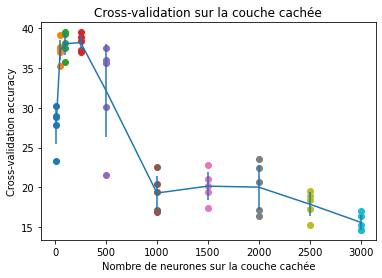

In [81]:
plt.figure()
for Dh in hidden_layer:
    accuracies = Dh_to_accuracies[Dh[0]]
    plt.scatter([Dh[0]] * len(accuracies), accuracies)
accuracies_mean = np.array([np.mean(v) for k,v in sorted(Dh_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(Dh_to_accuracies.items())])
plt.errorbar(hidden_layer, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation sur la couche cachée')
plt.xlabel('Nombre de neurones sur la couche cachée')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [82]:
i_max=list(accuracies_mean).index(np.max(accuracies_mean[1:]))
accuracy_max=np.max(accuracies_mean)
Dh_max=hidden_layer[i_max][0]
print("L'hyperparamètre nombre de neurones sur la couche cachée optimal et sa précision sont donc: Dh = %d, accuracy = %f" % (Dh_max, accuracy_max))

L'hyperparamètre nombre de neurones sur la couche cachée optimal et sa précision sont donc: Dh = 250, accuracy = 38.212500
